In [20]:
import argparse
import gc
import random
import torch
from PIL import Image
from torchvision.transforms import PILToTensor

import os
from tqdm import tqdm
from PIL import Image
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt


from src.models.sd_diffusion_extractor import SDFeaturizer
device  = torch.cuda.set_device(0)

In [21]:
#utils
def load_img(path, resize_to_512 = False):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    if resize_to_512:
      w, h = 512, 512
    else:
      fac = sqrt(512*512/w/h)
      w = int(w*fac)
      h = int(h*fac)
      w, h = map(lambda x: x - x % 64, (w + 63, h + 63))  # resize to integer multiple of 64
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


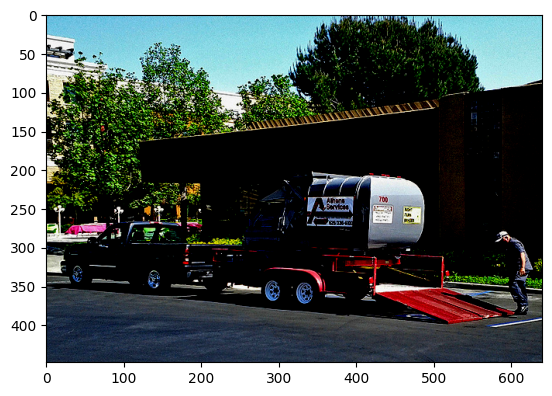

In [24]:
img = load_img('coco.jpg') # image as tensor
plt.imshow(img.squeeze().permute(1,2,0))

In [30]:
# extract the 'features' from the image.
sd_ft_extractor = SDFeaturizer()
img_ft = sd_ft_extractor.forward(img_tensor=img, prompt='a photo of a scene in a parking lot')

In [46]:
def visualize_tensor(tensor, cmap='plasma', marker='o', alpha=0.3, s=20):
    if not torch.is_tensor(tensor):
        raise ValueError("Input must be a PyTorch tensor")
    
    # Convert tensor to numpy array
    volume = tensor.numpy()
    
    # Normalize volume for better color mapping
    volume_normalized = (volume - volume.min()) / (volume.max() - volume.min())
     # Normalize volume for better color mapping
    #volume_normalized = volume #(volume - volume.min()) / (volume.max() - volume.min())

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    channels, height, width = volume.shape
    x, y, z = np.indices((channels, height, width))
    
    # Create scatter plot
    scatter = ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=volume_normalized.ravel(), cmap=cmap, marker=marker, alpha=alpha, s=s)
    
    ax.set_xlabel('C')
    #ax.set_xlim(0,channels)
    
    ax.set_ylabel('H')
    ax.set_ylim(0,height)

    
    ax.set_zlabel('W')
    ax.set_zlim(0,width)
    
    ax.set_title('3D Visualization of Tensor')
    plt.colorbar(scatter, ax=ax, shrink=0.5, label='Normalized Intensity')
    plt.tight_layout()
    plt.show()


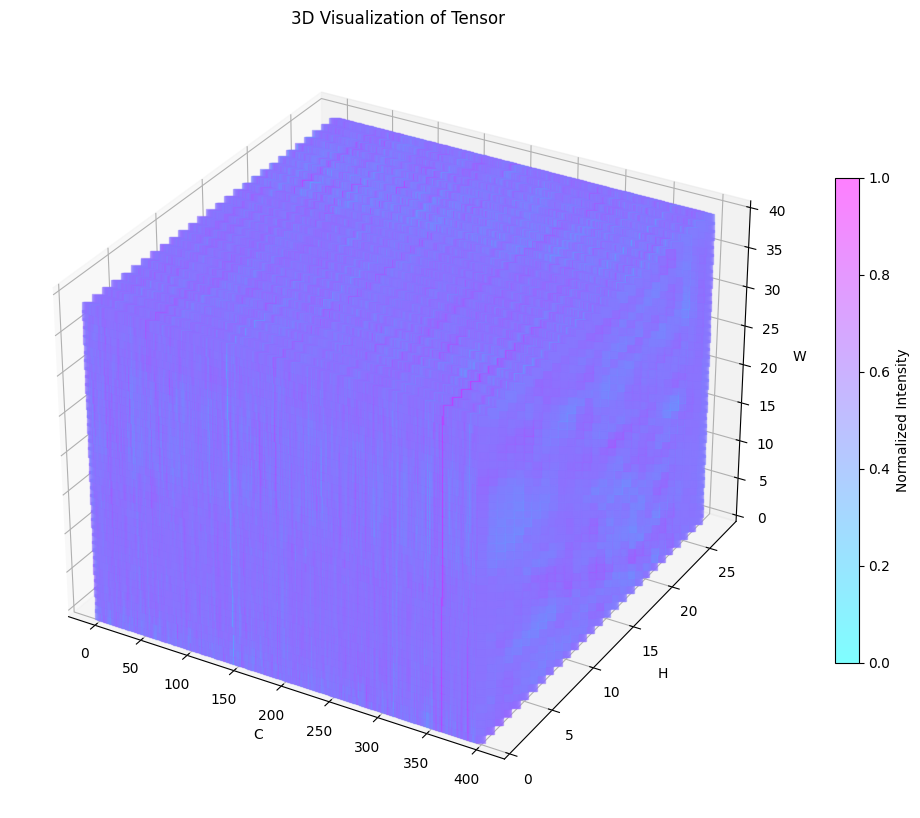

In [47]:
visualize_tensor(img_ft[0].cpu()[:400, :, :], s=50, alpha=0.5, marker='s', cmap='cool')